In [206]:
using CSV, DataFrames
using Plots; gr();
using LsqFit
using Printf

$$
Corr(\tau) = Corr(n\Delta t) = \langle P_{control}(m\Delta t)\cdot P_{perturbed}(m\Delta t + n\Delta t)\rangle
$$

Where $\langle\cdot\rangle$ denotes Pearson correlation. 

$P$ is fluorescence polarization

In [226]:
function corr(n, X, Y)
    M = length(X)
    
    if n >= 0
        X_mean = sum(X[1:(end - n)])/(M - n)
        Y_mean = sum(Y[(n + 1):end])/(M - n)
        X1 = X[1:(end - n)] .- X_mean
        Y1 = Y[(n + 1):end] .- Y_mean
    else
        n = abs(n)
        X_mean = sum(X[(n + 1):end])/(M - n)
        Y_mean = sum(Y[1:(end - n)])/(M - n)
        X1 = X[(n + 1):end] .- X_mean
        Y1 = Y[1:(end - n)] .- Y_mean
    end
    
    r = X1'*Y1/sqrt(X1'*X1)/sqrt(Y1'*Y1)
end

corr (generic function with 1 method)

$$ \phi = CT/24*2\pi$$

In [158]:
# read
df = CSV.read("data/20240619_phi_to_Delta_phi_M10.csv", DataFrame)
rename!(df, ["Nr", "Time_h", "Time_s", "Temp", names(df)[5:end]...])

# ditch some columns
select!(df, Not([:Nr, :Time_s, :C9, :D9]))
    
# pivot longer
df_l = stack(df, Not([:Time_h, :Temp]), variable_name=:Position, value_name=:FP)

# parse plate position to treatments and circadian times
df_l[!, :Treatment] = (x -> x[1] == 'C' ? :Control : :Perturbed).(df_l[!, :Position])
well2CT = x -> mod(24 - (x - 3)*4, 24)
df_l[!, :CT] = (x -> well2CT(parse(Int64, x[2]))).(df_l[!, :Position])
select!(df_l, Not([:Position]))
df_l

Row,Time_h,Temp,FP,Treatment,CT
,Float64,Float64,Int64,Symbol,Int64
1,0.0,30.2,149,Control,0
2,0.250056,30.2,146,Control,0
3,0.500056,30.2,147,Control,0
4,0.750056,30.0,145,Control,0
5,1.00006,30.0,147,Control,0
6,1.25006,30.3,145,Control,0
7,1.50008,30.2,147,Control,0
8,1.75008,30.2,146,Control,0
9,2.00008,30.0,145,Control,0


Calculate time-correlation between control and perturbed

In [227]:
corr_dict = Dict()

for CT in unique(df_l[!, :CT])
    corr_vec = []
    for i in -12:12    # up to 3 hours
        r = corr(i, df_l[df_l[!, :CT] .== CT .&& df_l[!, :Treatment] .== :Control, :FP],
                    df_l[df_l[!, :CT] .== CT .&& df_l[!, :Treatment] .== :Perturbed, :FP])
        corr_vec = [corr_vec; r]
    end
    corr_dict[CT] = corr_vec
end

Fit the phase to

$$
P(t) = B + A\sin(\frac{2\pi}{T}\cdot t + \phi - \frac{\pi}{2})
$$

In [198]:
function model(t, p)
    T, ϕ, A, B = p
    @. B + A*sin(2π/T*t + ϕ - π/2)
end

model (generic function with 1 method)

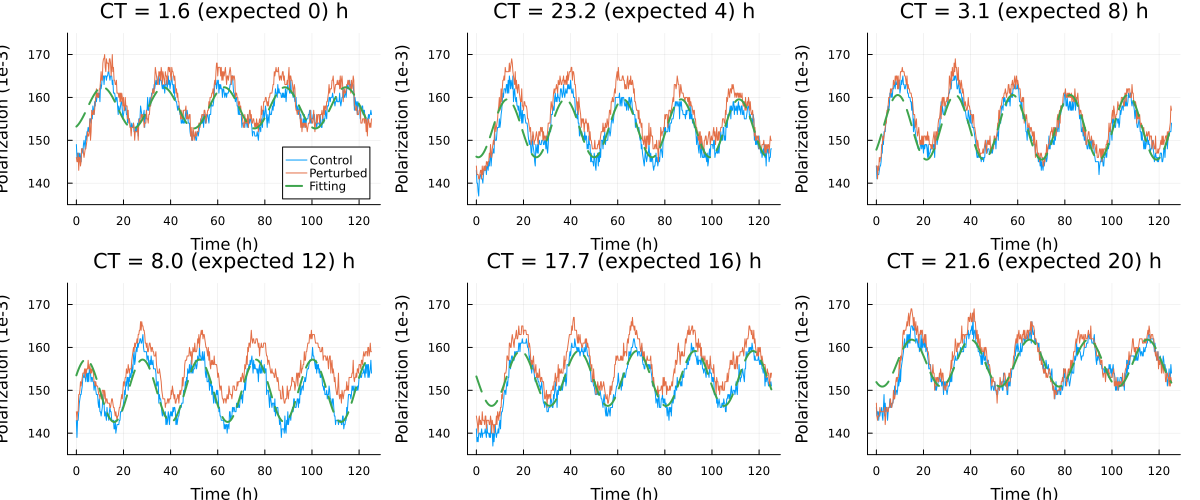

In [220]:
p_vec = []

p0 = [24., 0., 10., 160.]
lb = [0., -π, 3., 0.]
ub = [100., π, 100., 200.]

start = 24.

fitted_phase = Dict()

for CT in sort(unique(df_l[!, :CT]))
        tmp = df_l[df_l.CT .== CT, :]
        tmp_fit = tmp[tmp.Treatment .== :Control .&& tmp.Time_h .> start, :]
    
        fit = curve_fit(model, tmp_fit.Time_h, tmp_fit.FP, p0;
                        lower = lb, upper = ub)
        ϕ₀ = coef(fit)[2]
        ϕ₀ = ϕ₀ < 0 ? ϕ₀ + 2π : ϕ₀
        fitted_phase[CT] = ϕ₀*24/2π
        
        p = plot(tmp[tmp[!, :Treatment] .== :Control, :Time_h],
            tmp[tmp[!, :Treatment] .== :Control, :FP], 
            label="Control", title=(@sprintf "CT = %.1f (expected %i) h" fitted_phase[CT] CT),
            xlabel="Time (h)", ylabel="Polarization (1e-3)",
            ylim=(135, 175), legend=CT==0)
        plot!(tmp[tmp[!, :Treatment] .== :Perturbed, :Time_h],
                tmp[tmp[!, :Treatment] .== :Perturbed, :FP], label="Perturbed")
        
        # fitted curve
        t_vec = 0:0.1:maximum(tmp_fit.Time_h)
        plot!(t_vec, model(t_vec, coef(fit)), style=:dash, width=2, label="Fitting")
        p_vec = [p_vec; p]
end
pp = plot(p_vec..., layout=(2, 3), 
        size=(1200, 500), margin=3Plots.mm, fmt=:png)
display(pp)

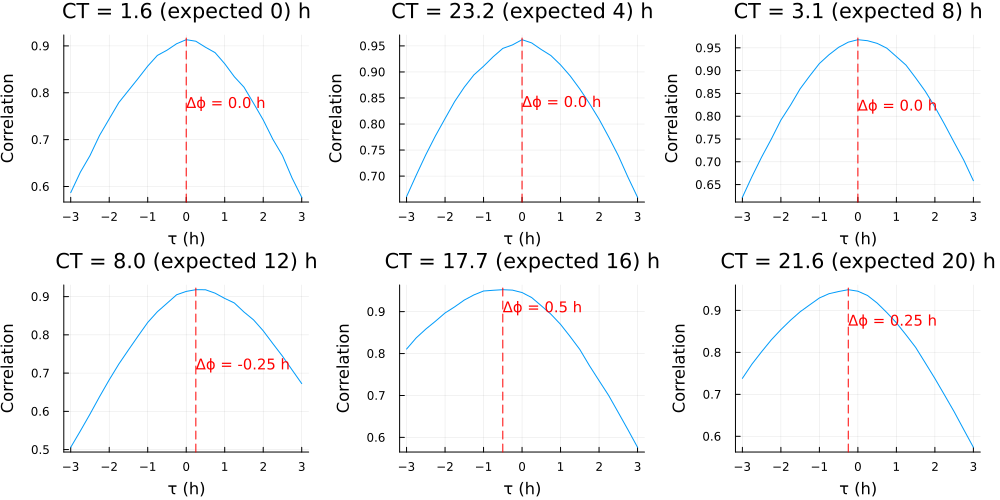

In [281]:
p_vec = []

Δϕ_dict = Dict()

for CT in sort(unique(df_l[!, :CT]))
    p = plot(-3:0.25:3, corr_dict[CT], 
            title=(@sprintf "CT = %.1f (expected %i) h" fitted_phase[CT] CT), 
            legend=false, xlabel="τ (h)", ylabel="Correlation")
    imax = argmax((i -> corr_dict[CT][i]), 1:length(corr_dict[CT]))
    Δϕ = (imax - 13)*0.25
    Δϕ_dict[CT] = abs(Δϕ) < 1e-6 ? 0. : -Δϕ
    vline!([Δϕ], c=:red, style=:dash)
    annotate!(Δϕ, corr_dict[CT][6],
            text("Δϕ = $(Δϕ_dict[CT]) h", :left, :red, 10))
    p_vec = [p_vec; p]
end

pp = plot(p_vec..., layout=(2, 3), 
        size=(1000, 500), margin=3Plots.mm, fmt=:png)
display(pp)

Visualize in the ring space

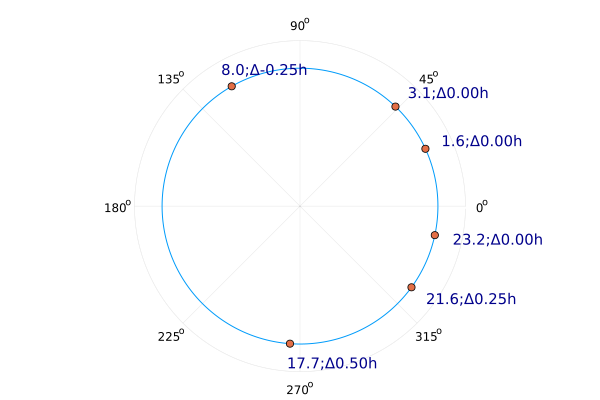

In [282]:
θ_vec = 0:0.01:2π
pp = plot(θ_vec, ones(length(θ_vec)), proj=:polar, ylim=(0, 1.2), legend=false, fmt=:png, yticks=false)

CT_vec = 0:4:20
scatter!(([fitted_phase[CT] for CT in CT_vec])/24*2π, ones(length(CT_vec)))

for CT in CT_vec
    plot!([0.], [0.], 
        annotations=(cos(fitted_phase[CT]/24*2π)*0.95,    # shift for aesthetics 
                    sin(fitted_phase[CT]/24*2π)*0.95, 
                    text((@sprintf "%.1f;Δ%.2fh" fitted_phase[CT] Δϕ_dict[CT]), :darkblue, :left, 10)))
end
    
display(pp)